# Estimating cell-specific gene regulatory networks using SNARE-seq and NOTMAD
SNARE-seq contains paired single-cell ATAC-seq and RNA-seq. By using open chromatin as context, we can estimate context-specific or cell-specific metagene relationships using NOTMAD. This notebook walks you through the application of NOTMAD and several baseline methods for regulatory network estimation, and provides convvenient plotting methods to visualize the power of sample-specific networks.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
tf_dtype = tf.dtypes.float32
import umap

from notmad.notmad import NOTMAD
from notmad.baselines import NOTEARS, ClusteredNOTEARS
from notmad.helpers import utils

# Load SNARE-seq data
Pre-cleaned and available at [https://github.com/blengerich/snareseq](https://github.com/blengerich/snareseq)

In [2]:
ar = np.load("data_files.npz", allow_pickle=True)

epi = ar['atac_train_small']
rna = ar['rna_train']
cell_types = ar['cell_type_train']
ct_list = sorted(list(set(cell_types)))

epi_pca = PCA(n_components=5)
epi_small = epi_pca.fit_transform(epi)
rna_pca = PCA(n_components=10)
rna_small = rna_pca.fit_transform(rna)

# Define some plotting and helper functions

In [3]:
# Helper functions for plotting.
def convert_to_one_hot(col):
    vals = list(set(col))
    one_hot_vars = np.array([vals.index(x) for x in col], dtype=np.float32)
    return one_hot_vars, vals

def plot_lowdim_rep(low_dim, labels, xlabel="UMAP 1", ylabel="UMAP 2",
                    min_samples=100, figdir=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))  # setup the plot
    cmap = plt.cm.jet  # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    tag, tag_names = convert_to_one_hot(labels)
    order = np.argsort(tag_names)
    tag_names = np.array(tag_names)[order]
    tag = np.array([list(order).index(int(x)) for x in tag])
    good_tags = [np.sum(tag == i) > min_samples for i in range(len(tag_names))]
    tag_names = np.array(tag_names)[good_tags]
    good_idxs = np.array([good_tags[int(tag[i])] for i in range(len(tag))])
    tag = tag[good_idxs]
    tag, _ = convert_to_one_hot(tag)
    bounds = np.linspace(0, len(tag_names), len(tag_names)+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    scat = ax.scatter(low_dim[good_idxs, 0], low_dim[good_idxs, 1],
                      c=tag, marker='+', alpha=0.7, cmap=cmap, norm=norm)
    plt.xlabel(xlabel, fontsize=48)
    plt.ylabel(ylabel, fontsize=48)
    plt.xticks([])
    plt.yticks([])

    # create a second axes for the colorbar
    ax2 = fig.add_axes([0.95, 0.15, 0.03, 0.7])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds+0.5,#boundaries=bounds,
                                   format='%1i')
    cb.ax.set_yticklabels(tag_names, fontsize=24)
    if figdir is not None:
        plt.savefig(f"{figdir}_umap.pdf", dpi=300, bbox_inches='tight')

# Plot raw single-cell RNA-seq and ATAC-seq data

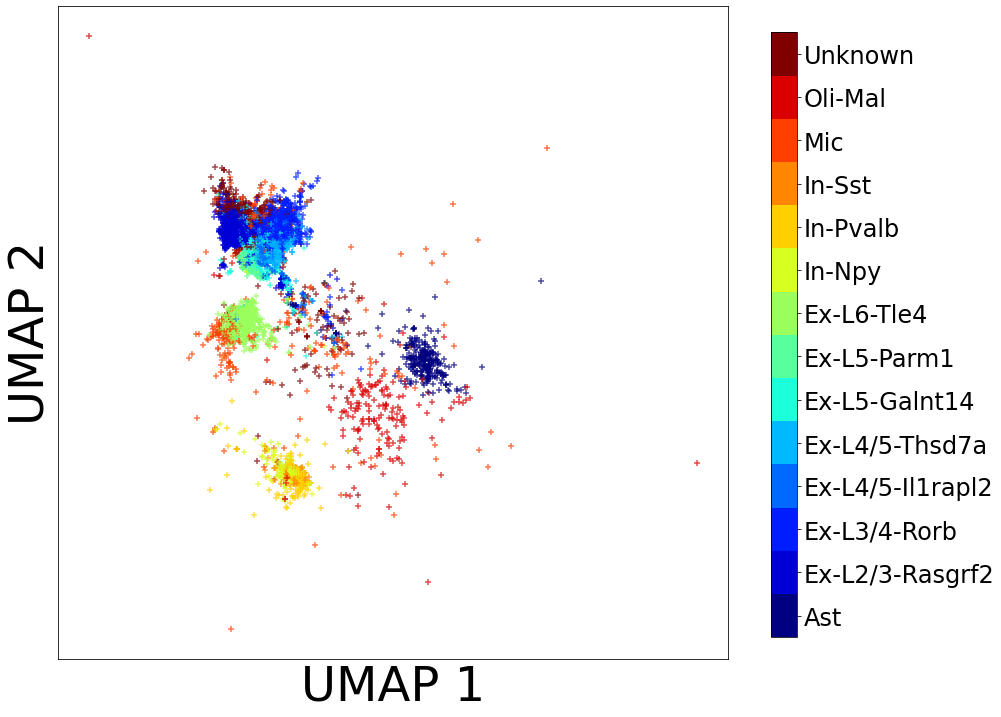

In [4]:
# Plot the raw scRNA-seq
reducer = umap.UMAP(n_components=2, densmap=True, n_neighbors=30, min_dist=0.001)
rna_small_small = reducer.fit_transform(rna_small)
plot_lowdim_rep(rna_small_small, cell_types, xlabel="UMAP 1", ylabel="UMAP 2", min_samples=100)

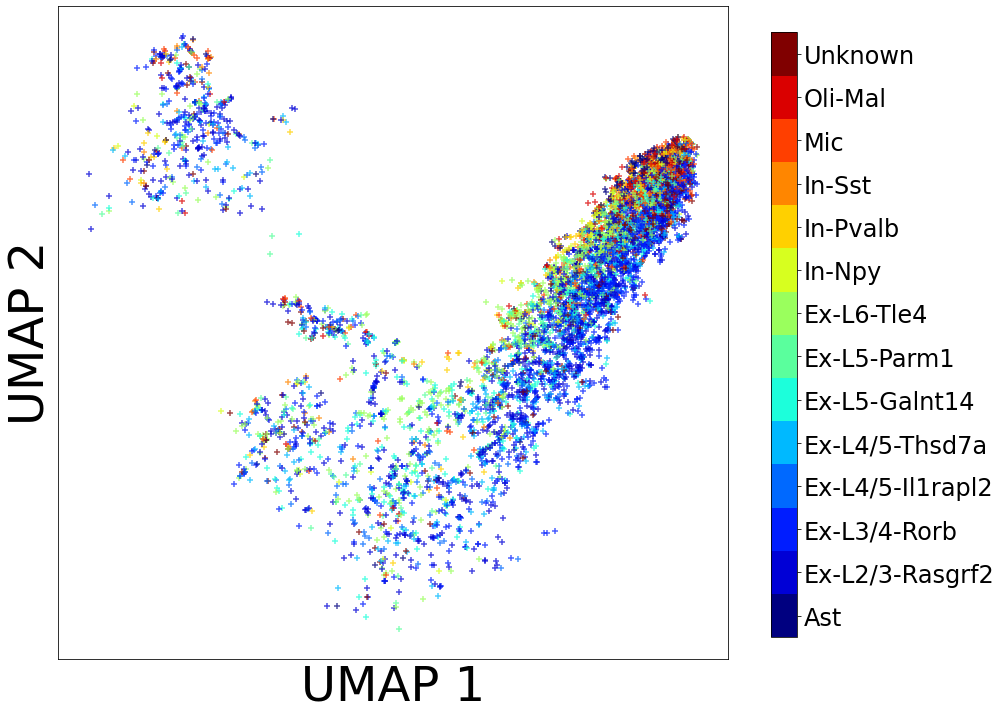

In [5]:
# Plot the raw scATAC-seq
epi_small_small = reducer.fit_transform(epi_small)
plot_lowdim_rep(epi_small_small, cell_types, xlabel="UMAP 1", ylabel="UMAP 2", min_samples=100)

# Normalize the data

In [6]:
# Pre-process and normalize data.
X = rna_small.astype(np.float32)
C = epi_small.astype(np.float32)
C = np.hstack((C, X[:, :2]))

# Get train-test split
train_idx, test_idx = train_test_split(range(len(X)), test_size=0.25, random_state=1)
X_train, X_test = X[train_idx], X[test_idx]
C_train, C_test = C[train_idx], C[test_idx]
cell_types_train, cell_types_test = cell_types[train_idx], cell_types[test_idx]
rna_train, rna_test = rna[train_idx], rna[test_idx]
epi_train, epi_test = epi[train_idx], epi[test_idx]

# Normalize the data
C_means = np.mean(C_train, axis=0)
C_stds = np.std(C_train, axis=0)
C_train -= C_means
C_test -= C_means
C_train /= C_stds
C_test /= C_stds

X_means = np.mean(X_train, axis=0)
X_stds = np.std(X_train, axis=0)
X_train -= X_means
X_test -= X_means
X_train /= X_stds
X_test /= X_stds

# First Baseline: Population NO-TEARS
This infers a single Bayesian network that minimizes the NO-TEARS loss on our entire scRNA-seq dataset

In [7]:
# Population Model
popnotears_params = {
    'loss_params': {'l1': 1e-3, 'init_alpha': 1e-2, 'init_rho': 1e-1},
    'context_shape': C_train.shape,
    'W_shape': (X_train.shape[-1], X_train.shape[-1])}
popnotears = NOTEARS(**popnotears_params)
popnotears.fit(C_train, X_train, 10, 1, val_split=0, )

Epoch 1/10
5172/5172 [==============================] - 12s 2ms/step - loss: 2.0884
Epoch 2/10
0.06324262 1.0
5172/5172 [==============================] - 11s 2ms/step - loss: 3.0999
Epoch 3/10
0.6587644 10.0
5172/5172 [==============================] - 8s 1ms/step - loss: 4.1047
Epoch 4/10
3.945396 100.0
5172/5172 [==============================] - 7s 1ms/step - loss: 4.6898
Epoch 5/10
24.279652 1000.0
5172/5172 [==============================] - 7s 1ms/step - loss: 4.9525
Epoch 6/10
101.885895 10000.0
5172/5172 [==============================] - 8s 1ms/step - loss: 5.0263
Epoch 7/10
5172/5172 [==============================] - 7s 1ms/step - loss: 5.0219
Epoch 8/10
437.50702 100000.0
5172/5172 [==============================] - 7s 1ms/step - loss: 5.0287
Epoch 9/10
2577.255 1000000.0
5172/5172 [==============================] - 7s 1ms/step - loss: 5.0365
Epoch 10/10
49440.793 10000000.0
5172/5172 [==============================] - 7s 1ms/step - loss: 5.0063
0.010026327 1.0
0.010499879

# Second Baseline: Context-clustered NO-TEARS
First, cluster the dataset according to the scATAC-seq data. Then infer a network using scRNA-seq data with NO-TEARS for each cluster

In [ ]:
# Clustered Model
def fit_clustered(loss_params, C_train, X_train, k):
    W_shape = (X_train.shape[-1], X_train.shape[-1])
    clustered = ClusteredNOTEARS(k, loss_params, C_train.shape, W_shape,
                 learning_rate=1e-2, tf_dtype=tf.dtypes.float32)
    clustered.fit(C_train, X_train, epochs=1000, batch_size=32, es_patience=1,
                  val_split=0.25, verbose=1)
    return clustered
clustered = fit_clustered(popnotears_params['loss_params'], C_train, X_train, 4)

# Third Baseline: Cell-type NO-NOTEARS
Segment the data according to expert cell-type knowledge. Then infer a Bayesian network using NO-TEARS for each cell-type.

In [8]:
# Cell Type-Specific Model
class FixedClusterer:
    def __init__(self, idx):
        self.cluster_idx = idx
    
    def fit(self, C):
        vals = np.squeeze(C[:, self.cluster_idx])
        self.vals = sorted(list(set(vals)))
    
    def predict(self, C):
        return np.array([self.vals.index(c) for c in C[:, self.cluster_idx]])
ct_predictor = FixedClusterer(idx=0)
ct_train = np.expand_dims([ct_list.index(x) for x in cell_types_train], 1)
ct_test = np.expand_dims([ct_list.index(x) for x in cell_types_test], 1)
ct_predictor.fit(ct_train)
W_shape = (X_train.shape[-1], X_train.shape[-1])
ct_specific = ClusteredNOTEARS(len(ct_predictor.vals), popnotears_params['loss_params'],
                                   [None, 1], W_shape, learning_rate=1e-2, tf_dtype=tf.dtypes.float32,
                                   clusterer=ct_predictor, clusterer_fitted=True)
ct_specific.fit(ct_train, X_train, epochs=1000, batch_size=32,
                    es_patience=1, val_split=0.25, verbose=0)

0.010026375 1.0
0.0105101 10.0
0.03839673 100.0
3.0904164 1000.0
251.13068 10000.0
0.010003916 1.0
0.010048788 10.0
0.011174469 100.0
0.1043962 1000.0
12.793231 10000.0
0.011859682 1.0
0.09496019 10.0
0.010004011 1.0
0.010050189 10.0
0.01124633 100.0
0.108243085 1000.0
12.8401165 10000.0
0.010925918 1.0
0.055751253 10.0
0.010056174 1.0
0.011564461 10.0
0.14280179 100.0
0.010134498 1.0
0.015094708 10.0
0.47000822 100.0
0.010104929 1.0
0.013718998 10.0
0.36241615 100.0
0.010016821 1.0
0.010297487 10.0
0.027216313 100.0
2.2842822 1000.0
0.010001006 1.0
0.010011563 10.0
0.0101663675 100.0
0.017102398 1000.0
0.7549682 10000.0
110.310844 100000.0
0.010364804 1.0
0.026519092 10.0
0.0100087095 1.0
0.010124083 10.0
0.01469573 100.0
0.5152876 1000.0
74.92696 10000.0
0.010008982 1.0
0.010126901 10.0
0.014532497 100.0
0.4872107 1000.0
67.92976 10000.0
0.010008898 1.0
0.010121302 10.0
0.0143270325 100.0
0.43465036 1000.0
53.891594 10000.0
0.010053171 1.0
0.011303484 10.0
0.122507714 100.0
13.673034

# Our Method: NOTMAD (Single-cell Networks)
Apply NOTMAD to the dataset, initializing the archetypes with cell-type networks and a few random networks.

In [9]:
# Archetype dictionary initializes with a combination of cell type-specific networks and uniform random networks.
ct_networks = [x.get_w() for x in ct_specific.notears_models]
A_tilde = np.zeros((25, X_train.shape[-1], X_train.shape[-1]))
k = len(A_tilde)
for i in range(k):
    if i < len(ct_networks):
        A_tilde[i] = ct_networks[i]
    else:
        A_tilde[i] = np.random.uniform(
            -0.1, 0.1, size=(X_train.shape[-1], X_train.shape[-1]))*np.random.binomial(1, 0.1, size=(X_train.shape[-1], X_train.shape[-1]))

init_mat = np.random.uniform(-0.1, 0.1, size=(k, X_train.shape[-1], X_train.shape[-1]))
sample_specific_loss_params = {'l1': 0., 'alpha': 2e1, 'rho': 1e0}
archetype_loss_params = {'l1': 0., 'alpha': 1e-1, 'rho': 1e-2}
build_notmad = lambda: NOTMAD(
    C_train.shape, X_train.shape, k,
    sample_specific_loss_params, archetype_loss_params,
    n_encoder_layers=3, encoder_width=16,
    encoder_type='gam', activation='relu',
    init_mat=A_tilde, learning_rate=1e-3,
    freeze_archs=False, project_archs_to_dag=True,
    project_distance=1.0, context_activity_regularizer=tf.keras.regularizers.l1(0),
    freeze_compat=False, init_compat=None, use_compatibility=False,
    update_compat_by_grad=False,
    pop_model=None, base_predictor=None
)

### Model Variance
NOTMAD trains with batch_size=1 to learn sample-specific models, leading to high model variance. To fix this, we apply bootstrapping.

In [10]:
# Fit bootstrapped NOTMAD model.
all_notmad = []
n_bootstraps = 5
for iteration in range(n_bootstraps):
    print(iteration)
    new_notmad = build_notmad()
    idxs = np.random.choice(len(C_train), size=int(0.7*len(C_train)))
    new_notmad.fit(C_train[idxs], X_train[idxs], batch_size=1, epochs=25, es_patience=1, verbose=1)
    all_notmad.append(new_notmad)

0


NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

1


NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

2


NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

3


NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

4


NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

NOTMAD Training:   0%|           0/25 ETA: ?s,  ?epochs/s

# Analyze the trained models

In [11]:
# Make predictions.
preds = {'pop': {}, 'cluster': {}, 'ct': {}, 'notmad': {}}
preds['pop']['train'] = popnotears.predict_w(C_train, project_to_dag=True)
preds['pop']['test'] = popnotears.predict_w(C_test, project_to_dag=True)
preds['cluster']['train'] = clustered.predict_w(C_train, project_to_dag=True)
preds['cluster']['test'] = clustered.predict_w(C_test, project_to_dag=True)
preds['ct']['train'] = ct_specific.predict_w(ct_train, project_to_dag=True)
preds['ct']['test'] = ct_specific.predict_w(ct_test, project_to_dag=True)
preds['notmad']['train'] = np.mean(np.array([
    nt.predict_w(C_train, project_to_dag=True) for nt in all_notmad]), axis=0)
preds['notmad']['test'] = np.mean(np.array([
    nt.predict_w(C_test, project_to_dag=True) for nt in all_notmad]), axis=0)

In [12]:
# Measure the error of predictions.
def analyze(C_train, X_train, C_test, X_test, preds, project):
    errs = {x: {'train': {}, 'test': {}} for x in preds.keys()}
    for i, ct in enumerate(ct_list):
        idxs_train = ct_train == i
        idxs_test  = ct_test == i
        idxs_train = np.squeeze(idxs_train)
        idxs_test  = np.squeeze(idxs_test)
        for model in errs.keys():
            errs[model]['train'][ct] = utils.mses_xw(X_train[idxs_train], preds[model]['train'][idxs_train])
            errs[model]['test'][ct] = utils.mses_xw(X_test[idxs_test], preds[model]['test'][idxs_test])
    return errs

def print_errs(errs):
    for model in errs:
        print("="*20)
        print(model)
        print('-'*10)
        all_train = []
        for k in errs[model]['train'].values():
            all_train.extend(k)
        print("Train MSE: {:.3f}".format(np.mean(all_train)))
        all_test = []
        for k in errs[model]['test'].values():
            all_test.extend(k)
        print("Test MSE: {:.3f}".format(np.mean(all_test)))

errs = analyze(C_train, X_train, C_test, X_test, preds, project=True)
print_errs(errs)

pop
----------
Train MSE: 0.501
Test MSE: 0.559
cluster
----------
Train MSE: 0.449
Test MSE: 0.502
ct
----------
Train MSE: 0.322
Test MSE: 0.371
notmad
----------
Train MSE: 0.255
Test MSE: 0.288


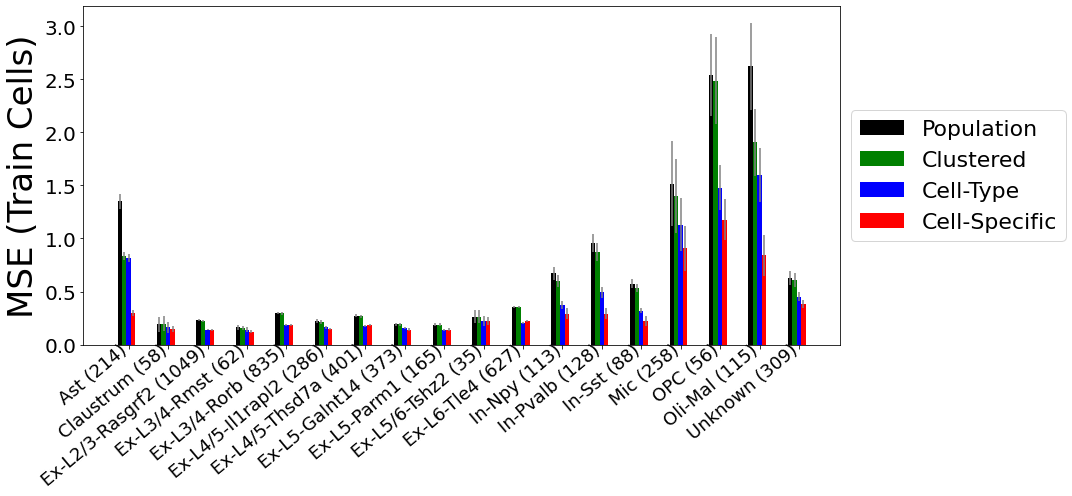

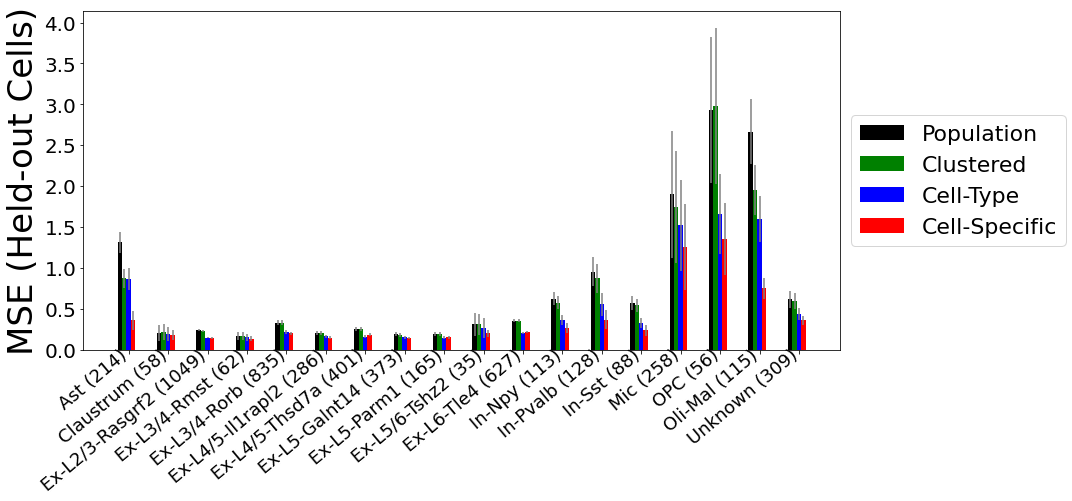

In [13]:
# Plot errors, split by tissue.
def plot_errs(errs, train_or_test, figdir=None):
    xticks = np.arange(len(ct_list))
    bars = 4
    width = 0.9/2
    offset = width / 2
    bar_width = width / bars
    plt.figure(figsize=(15,7))
    for i, ct in enumerate(ct_list):
        def my_plot(short_name, long_name, color, idx, with_legend):
            if with_legend:
                plt.bar(xticks[i] - offset + idx*bar_width, np.mean(errs[short_name][train_or_test][ct]), 
                    yerr=2*np.std(errs[short_name][train_or_test][ct])/np.sqrt(len(errs[short_name][train_or_test][ct])),
                        label=long_name, width=bar_width, color=color, ecolor='gray')
            else:
                plt.bar(xticks[i] - offset + idx*bar_width, np.mean(errs[short_name][train_or_test][ct]), 
                    yerr=2*np.std(errs[short_name][train_or_test][ct])/np.sqrt(len(errs[short_name][train_or_test][ct])),
                        width=bar_width, color=color, ecolor='gray')
        with_legend = i == len(ct_list) - 1
        my_plot('pop', 'Population', 'black', 0, with_legend)
        my_plot('cluster', 'Clustered', 'green', 1, with_legend)
        my_plot('ct', 'Cell-Type', 'blue', 2, with_legend)
        my_plot('notmad', 'Cell-Specific', 'red', 3, with_legend)
    plt.xticks(range(len(ct_list)),
               labels=["{} ({})".format(ct_list[i], int(np.sum(ct_train==i)))
                       for i in range(len(ct_list))],
               fontsize=18, rotation=40, rotation_mode='anchor',
               verticalalignment='baseline', horizontalalignment='right')
    lgd = plt.legend(fontsize=22, loc='center left', bbox_to_anchor=(1.0, 0.5))
    if train_or_test == 'train':
        plt.ylabel("MSE (Train Cells)", fontsize=34)
    else:
        plt.ylabel("MSE (Held-out Cells)", fontsize=34)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    if figdir is not None:
        plt.savefig(f"{figdir}_snareseq_mse_{train_or_test}.pdf".format(train_or_test), dpi=300,
                    bbox_inches='tight', bbox_extra_artists=[lgd])
    plt.show()

plot_errs(errs, 'train')
plot_errs(errs, 'test')

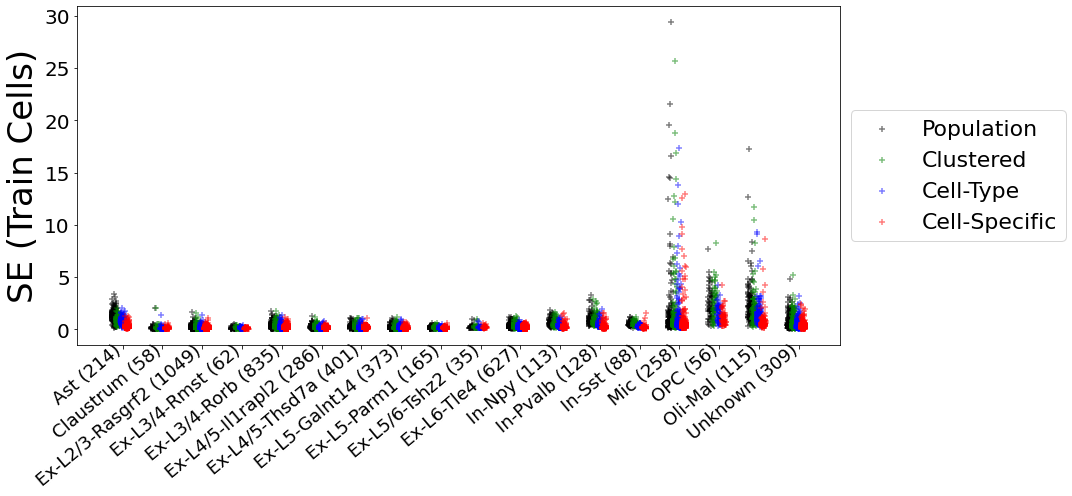

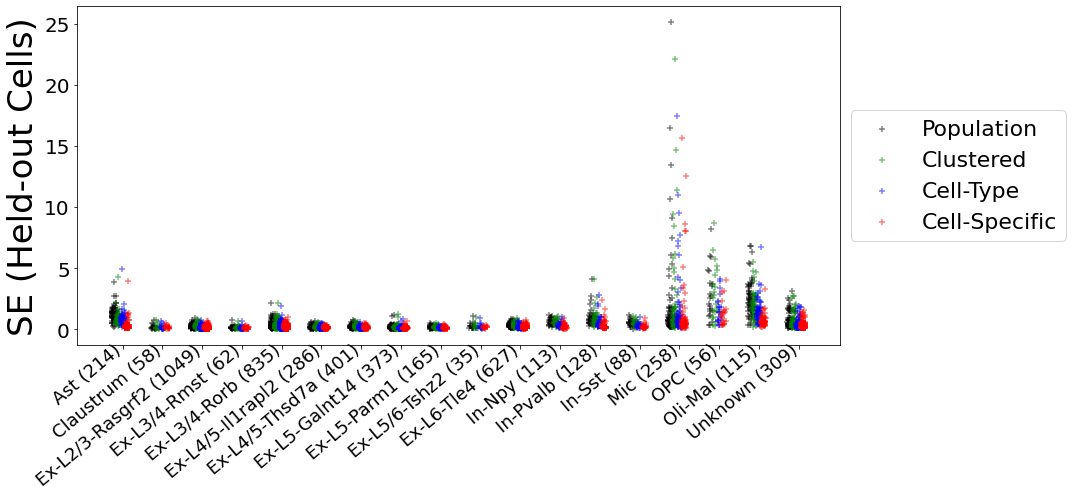

In [15]:
# Plot error distribution, split by tissue.
def plot_err_distributions(errs, train_or_test, figdir=None):
    xticks = np.arange(len(ct_list))
    bars = 4
    width = 0.9/2
    offset = width / 2
    bar_width = width / bars
    plt.figure(figsize=(15,7))
    for i, ct in enumerate(ct_list):
        def my_plot(short_name, long_name, color, idx, with_legend):
            if with_legend:
                x_center = xticks[i]-offset+idx*bar_width
                my_errs = errs[short_name][train_or_test][ct]
                plt.scatter(np.random.uniform(x_center-0.5*bar_width, x_center+0.5*bar_width, size=my_errs.shape),
                            my_errs, marker='+', color=color, label=long_name, alpha=0.5)
            else:
                x_center = xticks[i]-offset+idx*bar_width
                my_errs = errs[short_name][train_or_test][ct]
                plt.scatter(np.random.uniform(x_center-0.5*bar_width, x_center+0.5*bar_width, size=my_errs.shape),
                            my_errs, marker='+', color=color, alpha=0.5)
        with_legend = i == len(ct_list) - 1
        my_plot('pop', 'Population', 'black', 0, with_legend)
        my_plot('cluster', 'Clustered', 'green', 1, with_legend)
        my_plot('ct', 'Cell-Type', 'blue', 2, with_legend)
        my_plot('notmad', 'Cell-Specific', 'red', 3, with_legend)
    plt.xticks(range(len(ct_list)),
               labels=["{} ({})".format(ct_list[i], int(np.sum(ct_train==i))) 
                       for i in range(len(ct_list))],
               fontsize=18, rotation=40, rotation_mode='anchor',
               verticalalignment='baseline', horizontalalignment='right')
    lgd = plt.legend(fontsize=22, loc='center left', bbox_to_anchor=(1.0, 0.5))
    if train_or_test == 'train':
        plt.ylabel("SE (Train Cells)", fontsize=34)
    else:
        plt.ylabel("SE (Held-out Cells)", fontsize=34)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    if figdir is not None:
        plt.savefig(f"{figdir}_snareseq_mse_distribution_{train_or_test}.pdf", dpi=300,
                    bbox_inches='tight', bbox_extra_artists=[lgd])
    plt.show()

plot_err_distributions(errs, 'train')
plot_err_distributions(errs, 'test')

# Network Embeddings
How do single-cell network embeddings compare to the single-cell RNA-seq and ATAC-seq embeddings from before?

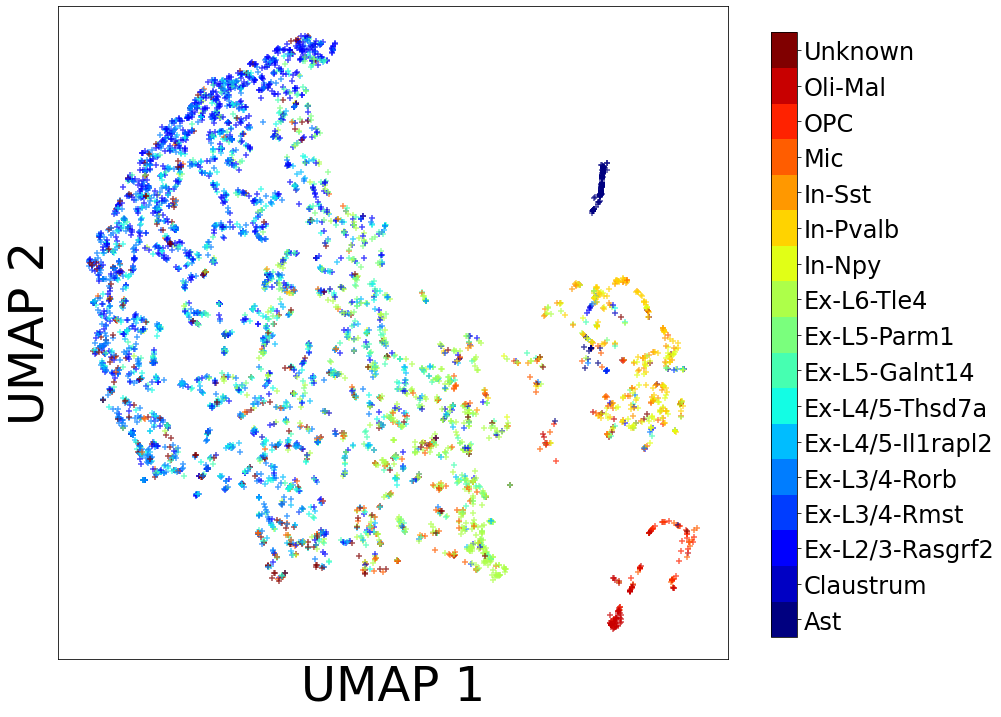

In [16]:
# Plot cell-specific networks. 
W_train_pred_flat = np.array([x.flatten() for x in preds['notmad']['train']])
W_train_pred_flat_small = reducer.fit_transform(W_train_pred_flat)
plot_lowdim_rep(W_train_pred_flat_small, labels=cell_types_train, min_samples=50)

# Archetypes as Regulatory Motifs
What patterns have we learned by constraining NOTMAD to a limited number of regulatory archetypes?

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Use the colorbar set_ticks() method instead.


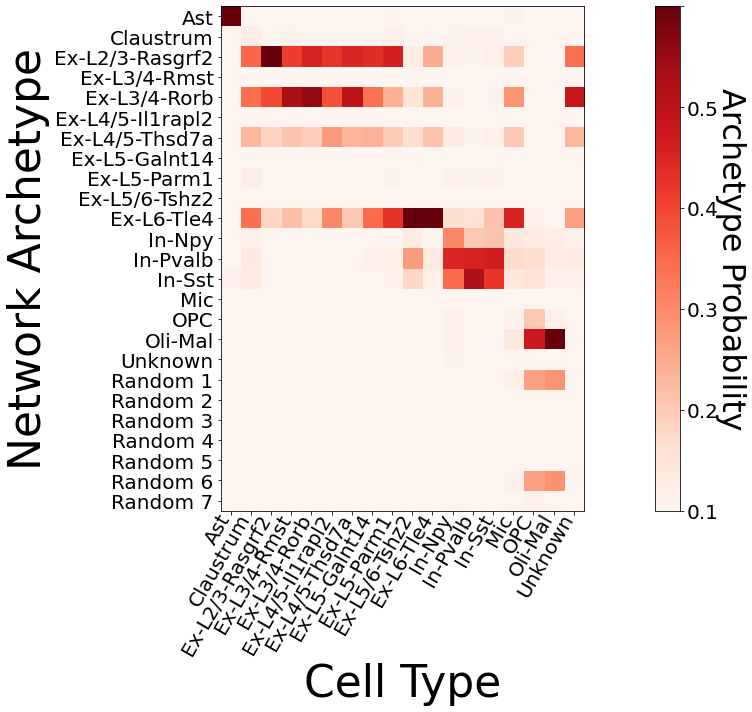

In [17]:
# Plot archetype selection by cell type.
arch_by_tissue = []
for ct in ct_list:
    tissue_idx = cell_types_train == ct
    C_tissue = C_train[tissue_idx]
    X_tissue = X_train[tissue_idx]
    exp_pred = np.mean([n.encoder(C_tissue.astype(np.float32)).numpy() for n in all_notmad], axis=0)
    exp_pred = exp_pred / np.expand_dims(np.sum(exp_pred, axis=1), 1)
    arch_by_tissue += [np.mean(exp_pred, axis=0)]

plt.figure(figsize=(20, 10))
plt.imshow(np.array(arch_by_tissue).T, cmap='Reds', vmin=-0.0, vmax=0.5)
plt.xticks(np.arange(len(ct_list)), ct_list, rotation=60, fontsize=20, rotation_mode='anchor',
           verticalalignment='baseline', horizontalalignment='right')
plt.ylabel('Network Archetype', fontsize=44)
plt.xlabel("Cell Type", fontsize=44)
arch_names = ct_list.copy()
arch_names.extend(["Random {}".format(1+i-len(ct_list)) for i in range(len(ct_list), len(A_tilde))])
plt.yticks(np.arange(len(arch_names)), arch_names, fontsize=20)
cax = plt.colorbar()
cax.ax.set_yticklabels([0.1, 0.2, 0.3, 0.4, 0.5], fontsize=20)
cax.ax.set_yticks(fontsize=20)
cax.ax.get_yaxis().labelpad = 27
cax.set_label("Archetype Probability", fontsize=32, rotation=270)
plt.tight_layout()
# plt.savefig('results/snareseq_activations.pdf', dpi=300, bbox_inches='tight')
plt.show()